<a href="https://colab.research.google.com/github/dexter7662/Pneumonia-identification-using-VGG19/blob/main/Pneumonia_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Flatten

Importing the dataset

In [2]:
os.environ['KAGGLE_USERNAME'] = "lorddexter"
os.environ['KAGGLE_KEY'] = "281706d18d96f899cdc0f5617516c67a"
!kaggle datasets download -d khoongweihao/covid19-xray-dataset-train-test-sets

 81% 68.0M/84.3M [00:00<00:00, 66.1MB/s]
100% 84.3M/84.3M [00:00<00:00, 108MB/s] 


In [3]:
!unzip covid19-xray-dataset-train-test-sets.zip

Archive:  covid19-xray-dataset-train-test-sets.zip
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0035-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0052-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0058-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0059-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0072-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0073-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0092-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0105-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0110-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0111-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0112-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0117-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0120

In [4]:
main = 'xray_dataset_covid19/'

In [5]:
train_normal = os.listdir(main + 'train/NORMAL')
train_pneumonia = os.listdir(main + 'train/PNEUMONIA')

test_normal = os.listdir(main + 'test/NORMAL')
test_pneumonia = os.listdir(main + 'test/PNEUMONIA')

Creating dataframes from directory

In [6]:
def dataframe(filenames, classes):
  return pd.DataFrame({'Filename': filenames, 'Label': [classes]*len(filenames)})

train_normal_df = dataframe(train_normal, 'Normal')
train_pneumonia_df = dataframe(train_pneumonia, 'Pneumonia')

test_normal_df = dataframe(test_normal, 'Normal')
test_pneumonia_df = dataframe(test_pneumonia, 'Pneumonia')

train_df = pd.concat([train_normal_df, train_pneumonia_df], axis=0)
test_df = pd.concat([test_normal_df, test_pneumonia_df], axis=0)

In [7]:
def pathmaker(df_name, df, empty_list):
    for i in df_name.values:
        if i[1] == 'Normal':
            empty_list.append(str(main + df + '/NORMAL/'+i[0]))
        else:
            empty_list.append(str(main + df + '/PNEUMONIA/'+i[0]))


#Empty list to be passed in path maker
train_path = []
test_path = []

#Assigning Path maker
pathmaker(train_df, 'train', train_path)
pathmaker(test_df, 'test', test_path)

train_df['Path'] = train_path
test_df['Path'] = test_path

#Shuffling / Re-arranging rows
train_df = train_df.sample(frac=1).reset_index(drop=True).iloc[:, 1:]
test_df = test_df.sample(frac=1).reset_index(drop=True).iloc[:, 1:]

train_df.head()

,Label,Path
0,Pneumonia,xray_dataset_covid19/train/PNEUMONIA/39EE8E69-...
1,Normal,xray_dataset_covid19/train/NORMAL/IM-0043-0001...
2,Pneumonia,xray_dataset_covid19/train/PNEUMONIA/6CB4EFC6-...
3,Pneumonia,xray_dataset_covid19/train/PNEUMONIA/covid-19-...
4,Normal,xray_dataset_covid19/train/NORMAL/IM-0006-0001...


Checking for any class inbalance

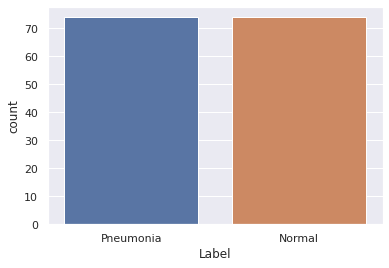

In [8]:
sns.set_theme(style="darkgrid")
sns.countplot(x='Label', data=train_df)

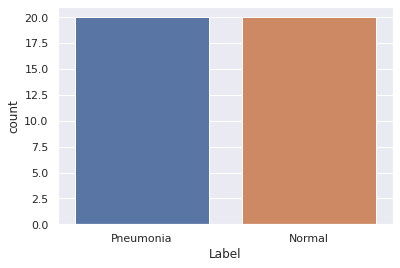

In [9]:
sns.set_theme(style="darkgrid")
sns.countplot(x='Label', data=test_df)

Creating the data input pipeline

In [10]:
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

In [11]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='Path',
    y_col='Label',
    subset='training',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    target_size=(224, 224),
    validate_filenames=False
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='Path',
    y_col='Label',
    subset='validation',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    target_size=(224, 224),
    validate_filenames=False
)

test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='Path',
    y_col=None,
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(224, 224),
    validate_filenames=False
)

Found 119 non-validated image filenames belonging to 2 classes.
Found 29 non-validated image filenames belonging to 2 classes.
Found 40 non-validated image filenames.


Designing model architecture

In [12]:
input = Input(shape=(224,224,3))
conv1 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1), padding='same', kernel_initializer= 'random_normal', bias_initializer= 'zeros')(input)
conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1), padding='same', kernel_initializer= 'random_normal', bias_initializer= 'zeros')(conv1)
pool1 = MaxPooling2D(pool_size=(2,2), strides=2)(conv2)
conv3 = Conv2D(filters=128, kernel_size=(3,3),strides=(1,1), padding='same', kernel_initializer= 'random_normal', bias_initializer= 'zeros')(pool1)
conv4 = Conv2D(filters=128, kernel_size=(3,3),strides=(1,1), padding='same', kernel_initializer= 'random_normal', bias_initializer= 'zeros')(conv3)
pool2 = MaxPooling2D(pool_size=(2,2), strides=2)(conv4)
conv5 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer= 'random_normal', bias_initializer= 'zeros')(pool2)
conv6 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer= 'random_normal', bias_initializer= 'zeros')(conv5)
conv7 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer= 'random_normal', bias_initializer= 'zeros')(conv6)
pool3 = MaxPooling2D(pool_size=(2,2), strides=2)(conv7)
conv8 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer= 'random_normal', bias_initializer= 'zeros')(pool3)
conv9 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer= 'random_normal', bias_initializer= 'zeros')(conv8)
conv10 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer= 'random_normal', bias_initializer= 'zeros')(conv9)
pool4 = MaxPooling2D(pool_size= (2,2), strides= 2)(conv10)
conv11 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer= 'random_normal', bias_initializer= 'zeros')(pool4)
conv12 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer= 'random_normal', bias_initializer= 'zeros')(conv11)
conv13 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer= 'random_normal', bias_initializer= 'zeros')(conv12)
pool5 = MaxPooling2D(pool_size= (2,2), strides= 2)(conv13)
flatten = Flatten()(pool5)
dense1 = Dense(units=4096,activation='relu', kernel_regularizer= l2(0.0005), kernel_initializer= 'random_normal', bias_initializer= 'zeros')(flatten)
dropout1 = Dropout(rate=0.5)(dense1)
dense2 = Dense(units=4096, activation='relu', kernel_regularizer= l2(0.0005), kernel_initializer= 'random_normal', bias_initializer= 'zeros')(dropout1)
dropout2 = Dropout(rate=0.5)(dense2)
output = Dense(units=2, activation='sigmoid', kernel_regularizer= l2(0.0005), kernel_initializer= 'random_normal', bias_initializer= 'zeros')(dropout2)
A = Model(inputs = input, outputs = output)
A.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0     

In [13]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name="Adam")
A.compile(optimizer= opt, metrics=['accuracy'], loss='categorical_crossentropy')

In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy') >= 0.9):
      print('\nReached 90% accuracy so cancelling training!')
      self.model.stop_training = True

myCallback_object = myCallback()

In [15]:
model = A.fit(x=train_generator, validation_data= validation_generator, epochs=25, callbacks=myCallback_object, batch_size=148)

Epoch 1/25
4/4 [==============================] - 254s 62s/step - loss: 344398.9375 - accuracy: 0.5507 - val_loss: 115662.9531 - val_accuracy: 0.5517
Epoch 2/25
4/4 [==============================] - 247s 61s/step - loss: 92033.7078 - accuracy: 0.7019 - val_loss: 5665.5439 - val_accuracy: 0.9310
Epoch 3/25
4/4 [==============================] - 243s 60s/step - loss: 48829.7937 - accuracy: 0.6370 - val_loss: 13266.5850 - val_accuracy: 0.6552
Epoch 4/25
4/4 [==============================] - 245s 61s/step - loss: 32617.2996 - accuracy: 0.7190 - val_loss: 4384.2349 - val_accuracy: 0.9310
Epoch 5/25
4/4 [==============================] - 243s 66s/step - loss: 15488.7287 - accuracy: 0.7385 - val_loss: 5702.8730 - val_accuracy: 0.8621
Epoch 6/25
4/4 [==============================] - 244s 61s/step - loss: 19862.4666 - accuracy: 0.7809 - val_loss: 6559.1279 - val_accuracy: 0.8621
Epoch 7/25
4/4 [==============================] - 246s 61s/step - loss: 10162.5838 - accuracy: 0.8326 - val_loss: 

Generating predictions using model

In [16]:
test_generator.reset()
y_pred = A.predict(test_generator)
print(y_pred)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


Converting Predictions to Labels

In [17]:
predicted_class_indices=np.argmax(y_pred,axis=1)

In [18]:
names = (train_generator.class_indices)
names = dict((v,k) for k,v in names.items())
predictions = [names[k] for k in predicted_class_indices]
print(predictions)

['Pneumonia', 'Pneumonia', 'Normal', 'Normal', 'Normal', 'Pneumonia', 'Normal', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Normal', 'Normal', 'Normal', 'Pneumonia', 'Normal', 'Pneumonia', 'Normal', 'Pneumonia', 'Normal', 'Pneumonia', 'Normal', 'Pneumonia', 'Pneumonia', 'Normal', 'Normal', 'Normal', 'Normal', 'Pneumonia', 'Normal', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Normal', 'Normal', 'Normal', 'Normal']


Calculating and Visualizing Confusion matrix

Text(0.5, 1.0, 'Confusion Matrix')

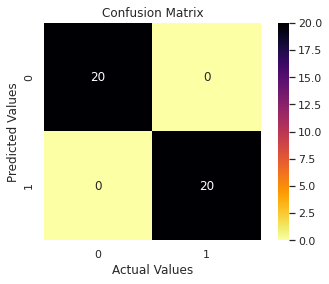

In [19]:
sns.heatmap(confusion_matrix(test_df['Label'], predictions), annot=True, cmap='inferno_r', square=True)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix')

In [20]:
accuracy = accuracy_score(test_df['Label'], predictions)
print(accuracy)

precision = precision_score(test_df['Label'], predictions, average='micro')
print(precision)


recall = recall_score(test_df['Label'], predictions, average='micro')
print(recall)

f1 = f1_score(test_df['Label'], predictions, average='micro')
print(f1)

1.0
1.0
1.0
1.0
